In [1]:
import laserhockey.hockey_env as h_env
import numpy as np
import torch
import time
from sac import SAC_Agent
from dsac import DSAC_Agent
import matplotlib.pyplot as plt



Using device: cpu
Using device: cpu


In [5]:
torch.manual_seed(42)
np.random.seed(42)

env = h_env.HockeyEnv()
agent = SAC_Agent(env.observation_space,env.action_space)
agent.load_network_states(torch.load("./results/best/SAC_against_itself_self_play-e44500-t32-s42-player2.pth", map_location=torch.device('cpu')))
agent.eval()
#agent.load_network_states(torch.load("SAC_run_easy-e1500-t32-s42-player.pth"))
opponent = h_env.BasicOpponent(weak=True)

loss = 0
win = 0
tie = 0

for run in range(0,100):
    ob, info = env.reset()
    ob_opponent = env.obs_agent_two()
    for t in range(1,400):
        action = agent.act(ob)
        opponent_action = opponent.act(ob_opponent)
        #opponent_action = np.zeros_like(opponent_action)
        ob_new,reward,done,trunc,info = env.step(np.hstack([action,opponent_action]))
        info_opponent = env.get_info_agent_two()
        #if info["reward_touch_puck"]!=0:
        #    print(info)
        #    print("touched")
        #time.sleep(0.05)
        #env.render()
        #print(info["reward_closeness_to_puck"])
        if done:
            if env.winner ==1:
                win +=1
                #if reward > 0:
                #    print(reward)
            elif env.winner == -1: 
                loss +=1
            else:
                tie +=1
            break
        #if reward > 0:
        #    print(reward)

        ob = ob_new
        ob_opponent = env.obs_agent_two()
print(info)
env.close()

print(f"win(left_side): {win},loss: {loss}, tie: {tie}")

halfed the action space to 4
Agent now in evaluation Mode
{'winner': 1, 'reward_closeness_to_puck': 0, 'reward_touch_puck': 0.0, 'reward_puck_direction': 0.0019295909118652345}
win(left_side): 100,loss: 0, tie: 0


In [ ]:
SAC self_play weak:  59  10  31 
SAC self_play hard:  70   9  21
SAC multi     weak: 100   0   0
SAC multi     hard:  62  23  15
DSAC          weak:  50  43   7
DSAC          hard:  92   7   1
DSAC self_playweak:  46  36  18        
DSAC self_playhard:  53  24  23


In [20]:
env.close()

In [ ]:
import matplotlib.pyplot as plt
import pickle

with open(f"SAC_Easy_easy-s42-e4500-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    q_losses =  np.asarray(data["q_losses"])
    pi_losses  = np.asarray(data["pi_losses"])
    temperature_losses = np.asarray(data["temperature_loss"])

In [2]:
DSAC_easy = np.load('DSAC_easy.npy', allow_pickle=True)
print(DSAC_easy)

[[102 303 595]
 [138 535 327]
 [301 421 278]
 [180 453 367]
 [235 487 278]
 [245 445 310]
 [298 464 238]
 [242 459 299]
 [285 467 248]
 [279 401 320]
 [254 370 376]
 [325 338 337]
 [444 245 311]
 [267 237 496]
 [402 245 353]
 [391 275 334]
 [392 281 327]
 [484 210 306]
 [470 279 251]
 [416 300 284]
 [365 232 403]
 [447 260 293]
 [497 265 238]
 [508 291 201]
 [491 319 190]
 [576 249 175]
 [535 279 186]
 [585 274 141]
 [572 307 121]
 [570 308 122]
 [535 291 174]
 [558 270 172]
 [619 274 107]
 [549 315 136]
 [530 320 150]
 [569 319 112]
 [558 279 163]
 [590 299 111]
 [655 256  89]
 [599 271 130]
 [655 220 125]]


In [3]:
def calculate_winrate(stats):
    return stats[:,0]/(stats[:,0]+stats[:,1]+stats[:,2])

In [7]:
def get_winrates(files):
    timelines = np.zeros((1,41))
    for file in files:
        stats = np.load(file, allow_pickle=True)
        winrate = calculate_winrate(stats)
        timelines = np.vstack([timelines,winrate])
    return timelines[1:]


def plot_timelines(title,timelines,legends):
    plt.figure(figsize=(14, 4))
    for i in range(len(legends)):
        winrate = timelines[i]
        stop = 20000+500
        plt.plot(range(0,stop,500),winrate,'-o')
        plt.legend(legends)

        #TODO add axis titles
    plt.grid(axis='x',color='grey', linestyle='--', linewidth=0.5, alpha=0.3)
    plt.xlabel("training episode")
    plt.ylabel("winrate")
    ticks = range(0,20200,500)
    plt.xticks(ticks)
    for index, tick in enumerate(plt.gca().xaxis.get_major_ticks()):
        if index % 2 != 0:
            tick.label1.set_visible(False) 

    y_tick_positions = np.arange(0,1.25,0.25)
    y_tick_labels = [f'{tick:.2f}' for tick in y_tick_positions]
    plt.yticks(y_tick_positions, y_tick_labels)
    
    y_grid_positions = [0,0.25, 0.5,0.75, 1]
    for y_grid in y_grid_positions:
        plt.axhline(y=y_grid, color='grey', linestyle='-', linewidth=0.5, alpha=0.1)
    

    plt.suptitle(title)
    plt.xlim(-80, 20100)
    plt.ylim(-0.05, None)
    plt.tight_layout()
    plt.savefig('example.png')

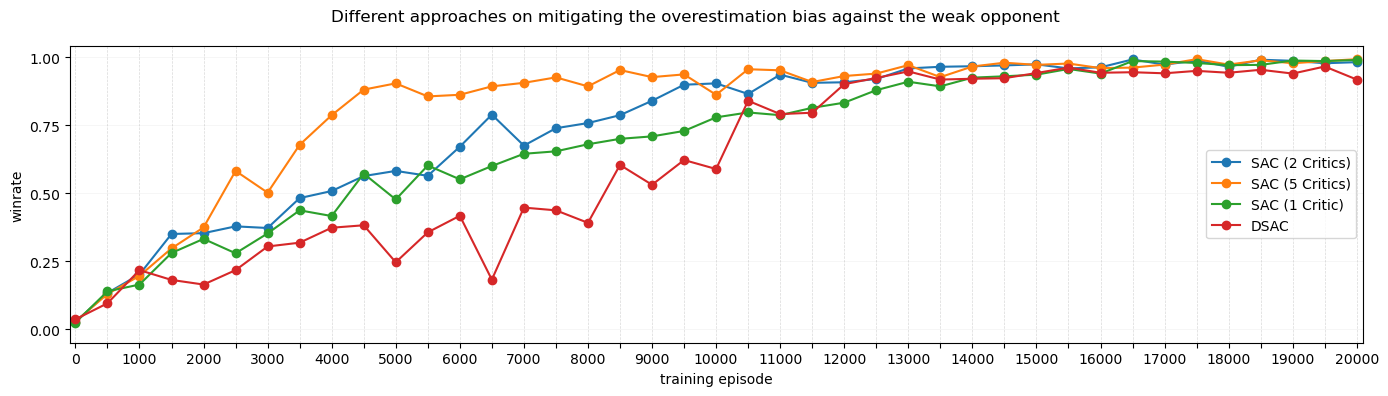

In [21]:
timeline = get_winrates(['./games/SAC_easy_vs_hard.npy','./games/singleCritics_vs_hard.npy','./games/multiCritics_vs_hard.npy','./games/DSAC_easy_vs_hard.npy'])
plot_timelines("Different approaches on mitigating the overestimation bias against the weak opponent",timeline,['SAC (2 Critics)','SAC (5 Critics)','SAC (1 Critic)','DSAC'])

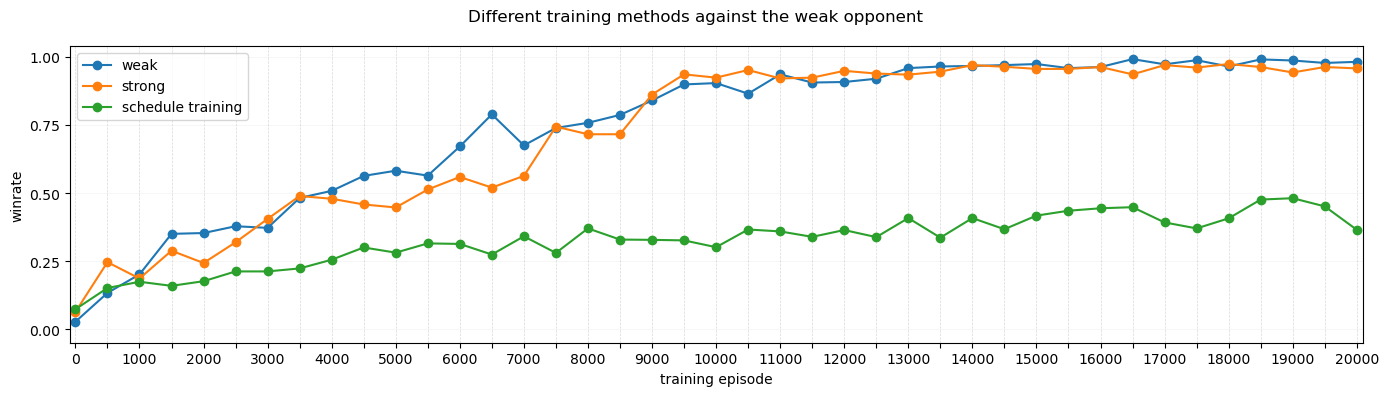

In [28]:
timeline = get_winrates(['./games/SAC_easy_vs_hard.npy','./games/SAC_hard_vs_easy.npy','./games/SAC_selfplay_vs_easy.npy'])
plot_timelines("Different training methods against the weak opponent",timeline,['weak','strong','schedule training'])

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

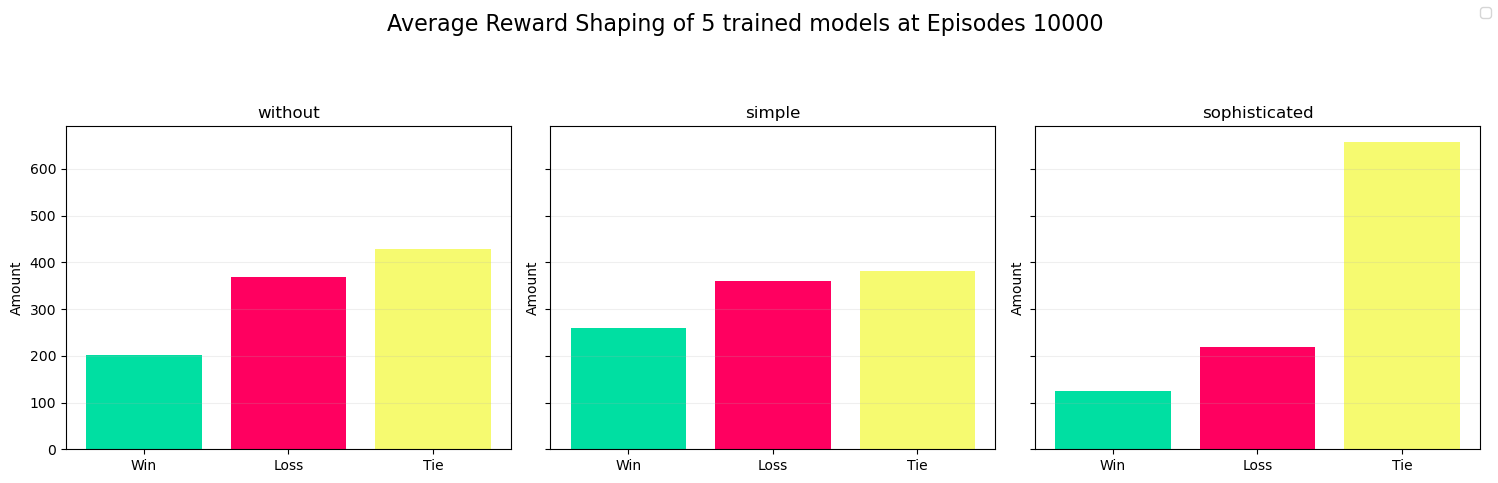

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some example data
categories = ['Win', 'Loss', 'Tie']
group_names = ['without', 'simple', 'sophisticated']
data = np.array([[202, 369, 429],
                [259, 359, 382],
                [124, 218, 658]])
data = data.T

# Define colors for each category
category_colors = ['#00DFA2','#FF0060', '#F6FA70']


# Create a 1x3 grid of subplots with shared y-axis
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Average Reward Shaping of 5 trained models at Episodes 10000', fontsize=16)

for i, ax in enumerate(axs):
    x = np.arange(len(group_names))
    for j in range(len(group_names)):
        ax.bar(x[j], data[j, i], align='center', color=category_colors[j])
    ax.set_title(f'{group_names[i]}', fontsize=12)

    # Set x-axis tick positions and labels for all plots
    ax.set_xticks(x)
    ax.set_xticklabels(categories)

    # Set y-axis tick positions and labels for the first plot
    if i == 0:
        y_ticks = np.arange(0, np.max(data) + 100, 100)  # Customize tick steps
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks)

    ax.set_ylabel('Amount')

    # Add horizontal grid lines to the background
    ax.yaxis.grid(True, linestyle='-', alpha=0.2, zorder=-1)

# Create a legend for the different categories
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('reward_shaping.png')
plt.show()

